Importation des modules d'interets

In [1]:
from xml.dom.minidom import Element
import numpy as np
import matplotlib.pyplot as plt
from random import gauss

Initialisation des paramètres

In [2]:
Qv1 = 10e-6/(60)# debit volumique (m^3/s)
Qv2=10e-6/(60)*0.018
Co_res = 0.2  # concentration O2 réserve (mol/m^3)
Cg_ini = 25  # concentration glucose initiale (mol/m^3)
Vr = 200*(10**(-6))  # volume reserve (m^3)
Ag = 5.6*(10**(-14))  # taux de croissance tissue (m^2/s)
alpha1 = 0.01
alpha2 = 0.03
alpha3 = 0.05
R1=6e-3
H = 40*(10**(-3))  # hauteur canal
R0 = 300*(10**(-6))  # rayon canal
Ko = 1.82*(10**(-3))  # cste MM oxyge
Kg = 0.3  # cste MM glucose
mu = 10**(-3)  # viscosité dynamique liquide
Vmax_O2 = 1.09e-17
Vmax_G = 9.5e-17
n = 100 # nombre de compartiments
Hc = H/n  # hauteur d'un compartiment (m)
Qc1=Qv1/200
Qc2=Qv2/200
ng_ini = Vr*Cg_ini  # qté de glucose initiale (mol)
phi = 2.5e13  # densité cellulaire (cellules/m^3)

Definition des fonctions de base

In [3]:
def Vg(r, CO2e, CGe,rayon,qi):  # calcul de Vg
    return Ag*f(tau(r,qi))*g(r)*h1(CO2(r, CO2e,rayon,qi))*h2(CGlucose(r, CGe,rayon,qi))

def f(tau):
    if tau >= 0 and tau < alpha1:
        return 0.5+0.5*(tau/alpha1) 
    elif tau >= alpha1 and tau < alpha2:
        return 1
    elif tau >= alpha2 and tau < alpha3:
        return (tau-alpha3)/(alpha2-alpha3)
    else:
        return 0

def g(r):
    return -1/r
def h1(Co):
    return Co/(Co+Ko)
def h2(Cg):
    return Cg/(Cg+Kg)
def tau(r,qi):
    return (4*mu*qi)/(np.pi*(r**3))
def CO2(r, CO2e,rayon,qi):  # calcul concentration O2 en sortie d'un compartiment (égale à la concentration dans le compartiment selon nos hypothèses)
    b = (Ko-CO2e+phi*Vmax_O2/qi*np.pi*(rayon**2-r**2)*Hc)
    return((-b+(b**2+4*Ko*CO2e)**0.5)/2)

def CGlucose(r, CGe,rayon,qi):  # calcul concentration glucose en sortie d'un compartiment
    b = (Kg-CGe+phi*Vmax_G/qi*np.pi*(rayon**2-r**2)*Hc)
    return((-b+(b**2+4*Kg*CGe)**0.5)/2)

def vitesse(r,qi,rayon):
    return(2*qi*(rayon**2-r**2)*Hc/(np.pi*r**4))

Définition de 2 fonction pour l'évolution du rayon du réacteur

In [ ]:
def evolution_R_rayon(dt, k, rayon,Qc):
    ls_T = [0]  
    ls_R = [[R0] for i in range(n)]
    ls_CO2 = [[Co_res] for i in range(n)]
    ls_CG = [[Cg_ini] for i in range(n)]
    conso_g = 0
    Volumes=[0]
    Cission=[[(4*mu*Qc)/(np.pi*(R0**3))]for i in range(n)]
    for i in range(k):
        v=0
        ls_T.append(ls_T[-1]+dt)
        for z in range(n):
            if z == 0:
                ls_CG[z].append((ng_ini-conso_g))
                ls_CO2[z].append(CO2(ls_R[z][-1], Co_res,rayon))
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1], ls_CO2[z][-1], ls_CG[z][-1],rayon))
                cg = np.pi*(R0**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg
                v+=np.pi*(R0**2-ls_R[z][-1]**2)*Hc
                Cission[z].append(tau(ls_R[z][-1]))
            else:
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1], ls_CO2[z][-1], ls_CG[z][-1],rayon))
                ls_CO2[z].append(CO2(ls_R[z][-1], ls_CO2[z-1][-1],rayon))
                ls_CG[z].append(CGlucose(ls_R[z][-1], ls_CG[z][-1],rayon))
                cg = np.pi*(R0**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg
                v+= np.pi*(R0**2-ls_R[z][-1]**2)*Hc
                Cission[z].append(tau(ls_R[z][-1]))
        Volumes.append(v*200/(H*np.pi*(R1)**2))
    return(ls_R[-1],ls_T,ls_R[0],ls_R[n//2])

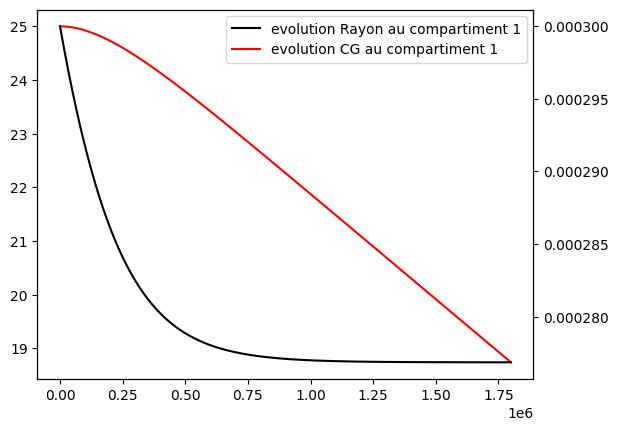

In [4]:
def evolution_R(dt,k,Qc):
    ls_T=[0]
    ls_R=[[R0] for i in range(n)]
    ls_CO2=[[Co_res] for i in range(n)]
    ls_CG=[[Cg_ini] for i in range(n)]
    conso_g=0
    Volumes=[0]
    Cission=[[(4*mu*Qc)/(np.pi*(ls_R[i][0]**3))]for i in range(n)]
    qi=Qc

    for i in range(k):
        ls_T.append(ls_T[-1]+dt)
        v=0
        for z in range(n):
            if z==0:
                ls_CG[z].append((ng_ini-conso_g)/Vr)
                ls_CO2[z].append(CO2(ls_R[z][-1],Co_res,qi,R0))
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],R0,qi))
                cg= dt*np.pi*(R0**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g+=cg*200
                Cission[z].append(tau(ls_R[z][-1],qi))
            else:
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],R0,qi))
                ls_CO2[z].append(CO2(ls_R[z][-1],ls_CO2[z-1][-1],qi,R0))
                ls_CG[z].append(CGlucose(ls_R[z][-1],ls_CG[z-1][-1],R0,qi))
                cg= dt*np.pi*(R0**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg*200
                Cission[z].append(tau(ls_R[z][-1],qi))
            v= np.pi*(R0**2-ls_R[z][-1]**2)*Hc
        Volumes.append(v*200/(H*np.pi*(R1)**2))
    return(ls_R,ls_T,Volumes,ls_CO2,ls_CG)

a = evolution_R(360, 5000,Qc1)
pl2=plt.plot(a[1],a[-1][1],'r',label='evolution CG au compartiment 1')
ax2=plt.gca().twinx()

pl1=ax2.plot(a[1],a[0][1],'k',label='evolution Rayon au compartiment 1')
plt.legend(pl1+pl2, [l.get_label() for l in pl1+pl2])
plt.show()


In [5]:




# def varaiation_Concentration_h(dt,k,ls_H):
#     ls_CO2=[]
#     ls_Cg=[]
#     ls_Cission=[]
#     for h in ls_H:
#         H=h*10**(-3)
#         a=evolution_R(dt,k,H)
#         ls_CO2.append(a[3][-1])
#         ls_Cg.append(a[4][-1])
#         Ciss=a[5][-1]*10**5
#         ls_Cission.append(Ciss)
    
#     plt.subplot(321)
#     plt.plot(ls_H,ls_CO2,'r*')
#     plt.ylabel("Concentration en CO2 finale")
#     plt.xlabel("Hauteur en mm")
#     plt.subplot(325)
#     plt.plot(ls_H,ls_Cg,'g*')
#     plt.ylabel("Concentration en Glucose finale")
#     plt.xlabel("Hauteur en mm")
#     plt.subplot(324)
#     plt.plot(ls_H,ls_Cission,'k*')
#     plt.ylabel("Cission finale en bar")
#     plt.xlabel("Hauteur en mm")
#     plt.show()

#varaiation_Concentration_h(360,5000,[10,20,30,40,50,60,70])



Variation de la hauteur

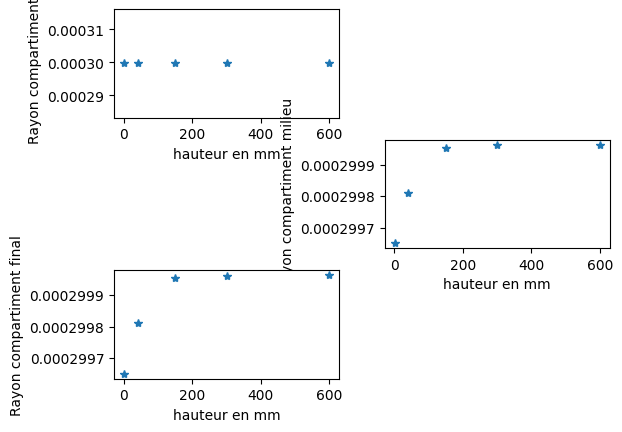

In [6]:
def Vg_h(r, CO2e, CGe,hauteur,qi):  # calcul de Vg
    return Ag*f(tau(r,qi))*g(r)*h1(CO2_h(r, CO2e,hauteur,qi))*h2(CGlucose(r, CGe,R0,qi))

def CO2_h(r, CO2e,hauteur,qi):  # calcul concentration O2 en sortie d'un compartiment (égale à la concentration dans le compartiment selon nos hypothèses)
    b = (Ko-CO2e+phi*Vmax_O2/qi*np.pi*(R0**2-r**2)*Hc)
    return((-b+(b**2+4*Ko*CO2e)**0.5)/2)

def CGlucose_h(r, CGe,rayon,qi):  # calcul concentration glucose en sortie d'un compartiment
    b = (Kg-CGe+phi*Vmax_G/qi*np.pi*(rayon**2-r**2)*Hc)
    return((-b+(b**2+4*Kg*CGe)**0.5)/2)

def evolution_R_hauteur(dt, k, hauteur):
    ls_T = [0]  
    ls_R = [[R0] for i in range(n)]
    ls_CO2 = [[Co_res] for i in range(n)]
    ls_CG = [[Cg_ini] for i in range(n)]
    conso_g = 0
    Volumes=[0]
    Cission=[[(4*mu*Qc1)/(np.pi*(R0**3))]for i in range(n)]
    for i in range(k):
        v=0
        ls_T.append(ls_T[-1]+dt)
        for z in range(n):
            if z == 0:
                ls_CG[z].append((ng_ini-conso_g)/Vr)
                ls_CO2[z].append(CO2_h(ls_R[z][-1], Co_res,hauteur,Qc1))
                ls_R[z].append(ls_R[z][-1]+dt*Vg_h(ls_R[z][-1], ls_CO2[z][-1], ls_CG[z][-1],hauteur,Qc1))
                cg = np.pi*(R0**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg
                v+=np.pi*(R0**2-ls_R[z][-1]**2)*Hc
                Cission[z].append(tau(ls_R[z][-1],Qc1))
            else:
                ls_R[z].append(ls_R[z][-1]+dt*Vg_h(ls_R[z][-1], ls_CO2[z][-1], ls_CG[z][-1],hauteur,Qc1))
                ls_CO2[z].append(CO2_h(ls_R[z][-1], ls_CO2[z-1][-1],hauteur,Qc1))
                ls_CG[z].append(CGlucose_h(ls_R[z][-1], ls_CG[z][-1],hauteur,Qc1))
                cg = np.pi*(R0**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg
                v+= np.pi*(R0**2-ls_R[z][-1]**2)*Hc
                Cission[z].append(tau(ls_R[z][-1],Qc1))
        Volumes.append(v*200/(H*np.pi*(R1)**2))
    return(ls_R[-1],ls_T,ls_R[0],ls_R[n//2])

def varaiation_r_h(dt,k,ls_H):
    ls_R0=[]
    ls_Rm=[]
    ls_rd=[]
    for h in range(len(ls_H)):
        H=ls_H[h]*10**(-3)
        a=evolution_R_hauteur(dt,k,H)
        ls_R0.append(a[2][10])
        ls_Rm.append(a[3][10])
        ls_rd.append(a[0][10])
    plt.subplot(321)
    plt.plot(ls_H,ls_R0,'*')
    plt.ylabel("Rayon compartiment 0")
    plt.xlabel("hauteur en mm")
    plt.subplot(324)
    plt.plot(ls_H,ls_Rm,'*')
    plt.ylabel("Rayon compartiment milieu")
    plt.xlabel("hauteur en mm")
    plt.subplot(325)
    plt.plot(ls_H,ls_rd,'*')
    plt.ylabel("Rayon compartiment final")
    plt.xlabel("hauteur en mm")
    plt.show()
varaiation_r_h(360,5000,[1,40,150,300,600])


Definition fonction pour optimisation

In [7]:
def evolution_optimisation_debit(dt,k,qi,rayon):
    ls_T=[0]
    ls_R = [[rayon] for i in range(n)]
    ls_CO2=[[Co_res] for i in range(n)]
    ls_CG=[[Cg_ini] for i in range(n)]
    conso_g=0
    Volumes=[0]
    Cission=[[(4*mu*qi)/(np.pi*(ls_R[i][0]**3))]for i in range(n)]
    v_prod=[[-1*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],ls_R[z][0],qi)]for z in range(n)]
    for _ in range(k):
        ls_T.append(ls_T[-1]+dt)
        v=0
        if ls_T[-1]>9.5*24*3600:
            qi=Qc2
        for z in range(n):
            if z==0:
                ls_CG[z].append((ng_ini-conso_g)/Vr)
                if ls_CG[0][-1]<Kg:
                    ls_CG[0][-1]=Cg_ini
                ls_CO2[z].append(CO2(ls_R[z][-1],Co_res,rayon,qi))
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],rayon,qi))
                cg= dt*np.pi*(rayon**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g+=cg*200
                Cission[z].append(tau(ls_R[z][-1],qi))
                v_prod[z].append(-1*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],rayon,qi))
            else:
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],rayon,qi))
                ls_CO2[z].append(CO2(ls_R[z][-1],ls_CO2[z-1][-1],rayon,qi))
                ls_CG[z].append(CGlucose(ls_R[z][-1],ls_CG[z-1][-1],rayon,qi))
                cg= dt*np.pi*(rayon**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg*200
                Cission[z].append(tau(ls_R[z][-1],qi))
                v_prod[z].append(-1*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],rayon,qi))
            v+= np.pi*(rayon**2-ls_R[z][-1]**2)*Hc
        Volumes.append(v*200/(H*np.pi*(R1)**2))
    return(ls_R,ls_T,ls_CO2,ls_CG,Volumes,v_prod)

def evolution_R_debit_optimal(dt,k,Q,rayon,n0):
    ls_T=[0]
    ls_R = [[rayon] for i in range(n)]
    ls_CO2=[[Co_res] for i in range(n)]
    ls_CG=[[Cg_ini] for i in range(n)]
    conso_g=0
    Volumes=[0]
    qi=Q/n0
    Cission=[[(4*mu*qi)/(np.pi*(ls_R[i][0]**3))]for i in range(n)]
    v_prod=[[-1*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],ls_R[z][0],qi)]for z in range(n)]
    for i in range(k):
        ls_T.append(ls_T[-1]+dt)
        v=0
        for z in range(n):
            if z==0:
                ls_CG[z].append((ng_ini-conso_g)/Vr)
                if ls_CG[0][-1]<Kg:
                    ls_CG[0][-1]=Cg_ini
                ls_CO2[z].append(CO2(ls_R[z][-1],Co_res,ls_R[z][0],qi))
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],ls_R[z][0],qi))
                cg= dt*np.pi*(ls_R[z][0]**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g+=cg*n0
                Cission[z].append(tau(ls_R[z][-1],qi))
                v_prod[z].append(-1*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],ls_R[z][0],qi))
            else:
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],ls_R[z][0],qi))
                ls_CO2[z].append(CO2(ls_R[z][-1],ls_CO2[z-1][-1],ls_R[z][0],qi))
                ls_CG[z].append(CGlucose(ls_R[z][-1],ls_CG[z-1][-1],ls_R[z][0],qi))
                cg= dt*np.pi*(ls_R[z][0]**2-ls_R[z][-1]**2)*Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg*n0
                Cission[z].append(tau(ls_R[z][-1],qi))
                v_prod[z].append(-1*Vg(ls_R[z][-1],ls_CO2[z][-1],ls_CG[z][-1],ls_R[z][0],qi))
            v+= np.pi*(ls_R[z][0]**2-ls_R[z][-1]**2)*Hc
        Volumes.append(v*n0/(H*np.pi*(R1)**2))
    return(ls_R,ls_T,ls_CO2,ls_CG,Volumes,v_prod)

Variation du débit avec les conditions optimales
On fait notamment un changement de valeur de débit au cours de l'exp

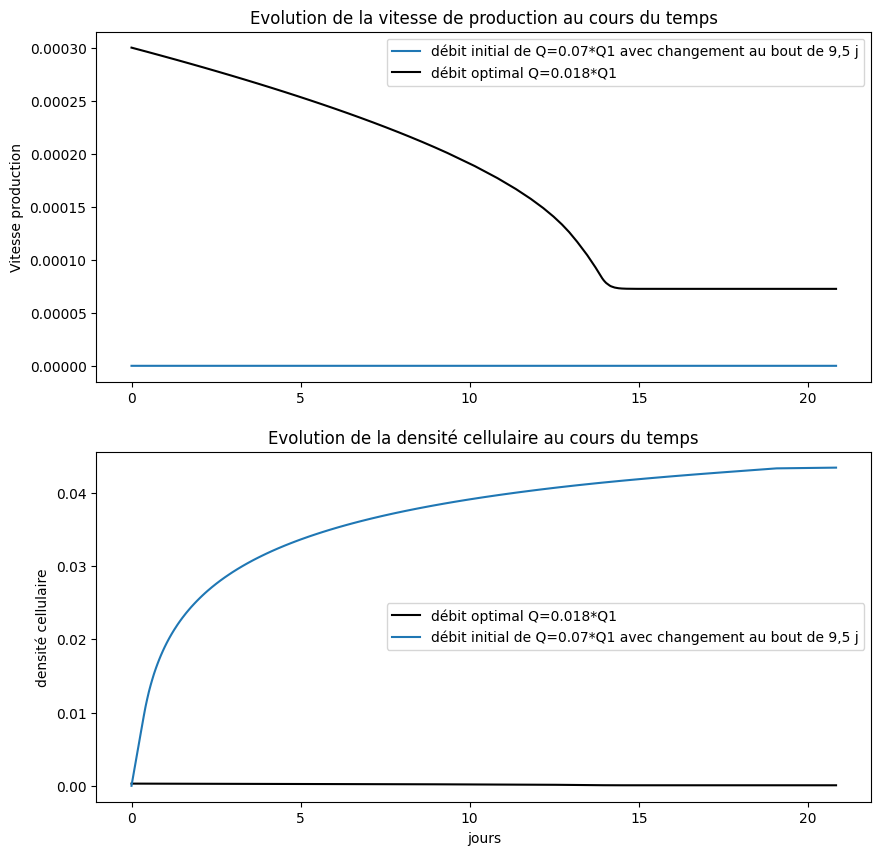

In [23]:
def variation_debit(dt,k,ls_debit):
    a1=evolution_optimisation_debit(dt,k,Qc2,R0)
    fig,ax=plt.subplots(2,1)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    for elem in ls_debit:
        a=evolution_R_debit_optimal(dt,k,elem,R0,200)
        for i in range(len(a[1])):
            a[1][i]=round(a[1][i]/(24*3600), ndigits=3)
        ax[0].plot(a[1],a[5][0],label="débit initial de Q=0.07*Q1 avec changement au bout de 9,5 j") 
        ax[0].set_title("Evolution de la vitesse de production au cours du temps")
        ax[0].plot(a[1],a1[0][0],'k',label='débit optimal Q=0.018*Q1')
        ax[0].set_ylabel('Vitesse production')        
        ax[0].legend()
        ax[1].set_title("Evolution de la densité cellulaire au cours du temps")
        ax[1].plot(a[1],a1[0][0],'k',label='débit optimal Q=0.018*Q1')
        ax[1].plot(a[1],a[4],label='débit initial de Q=0.07*Q1 avec changement au bout de 9,5 j')
        ax[1].set_ylabel('densité cellulaire')
        ax[1].set_xlabel("jours")
        ax[1].legend()
    plt.show()
    
variation_debit(360,5000,[0.07*Qc1])

Variation du Rayon

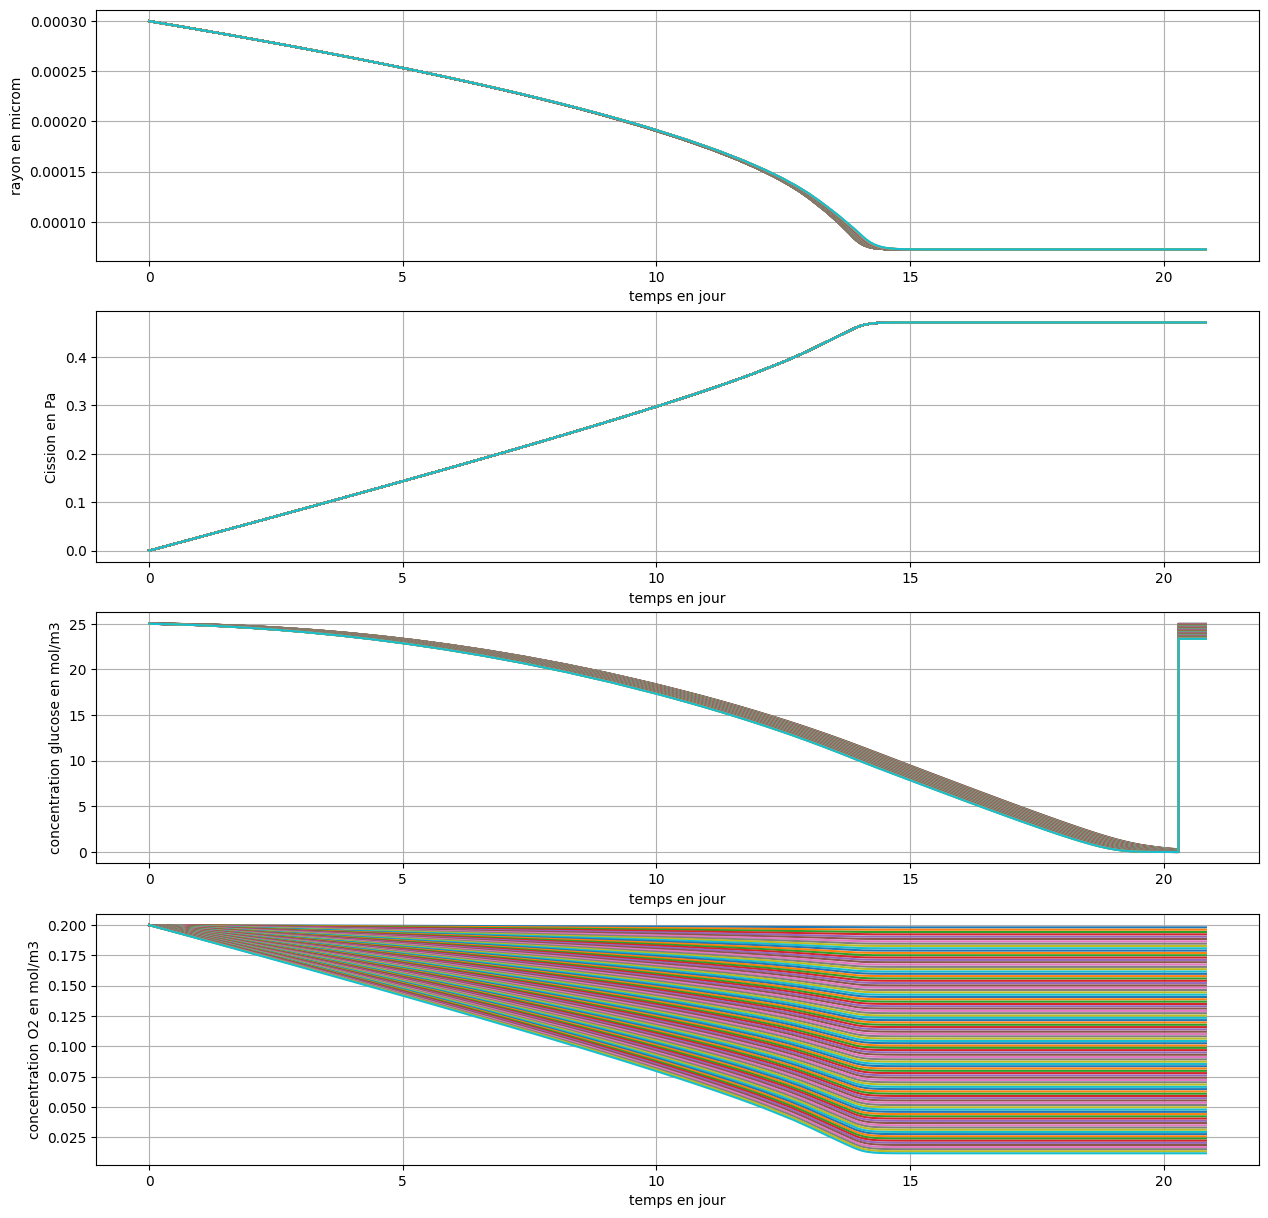

In [19]:
def variation_r_R0(dt,k):
    a=evolution_optimisation_debit(dt,k,Qc2,R0)
    fig,ax=plt.subplots(4,1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(len(a[1])):
        a[1][i]=round(a[1][i]/(24*3600), ndigits=3)
    for z in range(len(a[0])):
        # plt.plot(a[1],a[0][z],label='compartiment '+str(z+1)+' où R0='+str(round(a[0][z][0]*10**6,ndigits=2))+' microm')
        ax[0].plot(a[1],a[0][z])
        ax[0].set_xlabel('temps en jour')
        ax[0].set_ylabel('rayon en microm')
        # ax[0].legend(prop={'size': 9},bbox_to_anchor=(1.75, 1))
        ax[0].grid(True)
        ax[1].plot(a[1],a[4])
        ax[1].set_xlabel('temps en jour')
        ax[1].grid(True)
        ax[1].set_ylabel('Cission en Pa')
        ax[1].set_xlabel('temps en jour')
        ax[2].plot(a[1],a[3][z])
        ax[2].set_ylabel('concentration glucose en mol/m3')   
        ax[2].set_xlabel('temps en jour')     
        ax[2].grid(True)
        ax[3].plot(a[1],a[2][z])
        ax[3].set_ylabel('concentration O2 en mol/m3')  
        ax[3].set_xlabel('temps en jour')      
        ax[3].grid(True)

    plt.show()

variation_r_R0(360,5000)


Variation rayon selon différents débits et rayons initiaux

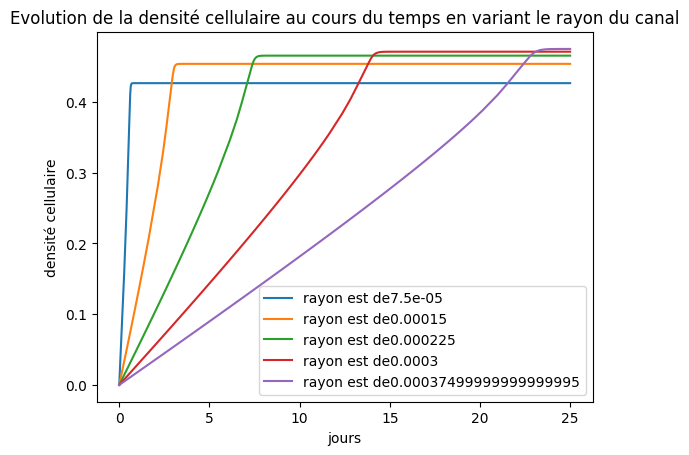

In [10]:
def variaton_rayon(dt,k,debit,ls_n,ls_rayon):
    for r in range(len(ls_rayon)):
        a=evolution_R_debit_optimal(dt,k,debit,ls_rayon[r],ls_n[r])
        for i in range(len(a[1])):
            a[1][i]=round(a[1][i]/(24*3600), ndigits=3)
        plt.plot(a[1],a[4], label='rayon est de' + str(ls_rayon[r]))
        plt.xlabel('jours')
        plt.ylabel('densité cellulaire')
        plt.title('Evolution de la densité cellulaire au cours du temps en variant le rayon du canal')
        plt.legend()
    plt.show()

variaton_rayon(360,6000,Qv2,[3200,800,356,200,128],[0.25*R0,0.5*R0,0.75*R0,R0,1.25*R0])


On visualise la rugosité d'un potentiel en décomposant l'os en compartiment de rayons initiaux à reartition gaussienne

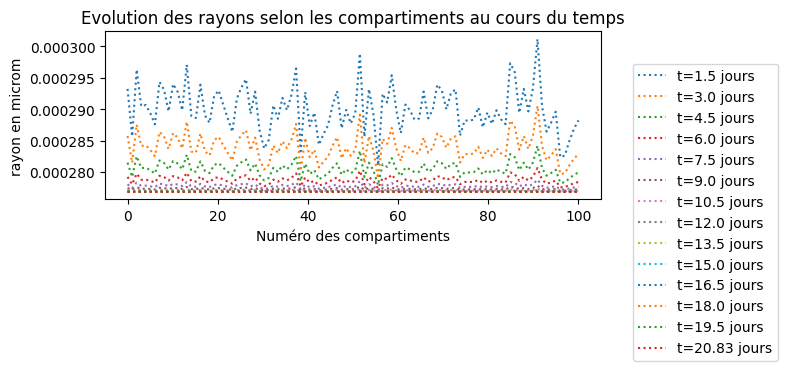

In [11]:
def evolution_R_aleatoire(dt, k):
    ls_T = [0]
    ls_R = [[gauss(R0, 0.02*R0)] for i in range(n)]
    ls_CO2 = [[Co_res] for i in range(n)]
    ls_CG = [[Cg_ini] for i in range(n)]
    conso_g = 0
    Volumes = [0]
    Cission = [[(4*mu*Qc1)/(np.pi*(ls_R[i][0]**3))]for i in range(n)]

    for i in range(k):
        ls_T.append(ls_T[-1]+dt)
        v = 0
        for z in range(n):

            if z == 0:
                ls_CG[z].append((ng_ini-conso_g)/Vr)
                if ls_CG[0][-1] < 10:
                    ls_CG[0][-1] = Cg_ini
                ls_CO2[z].append(CO2(ls_R[z][-1], Co_res, ls_R[z][0],Qc1))
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],
                               ls_CO2[z][-1], ls_CG[z][-1], ls_R[z][0],Qc1))
                cg = dt*np.pi*(ls_R[z][0]**2-ls_R[z][-1]**2) * \
                    Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg*200
                Cission[z].append(tau(ls_R[z][-1],Qc1))
            else:
                ls_R[z].append(ls_R[z][-1]+dt*Vg(ls_R[z][-1],
                               ls_CO2[z][-1], ls_CG[z][-1], ls_R[z][0],Qc1))
                ls_CO2[z].append(CO2(ls_R[z][-1], ls_CO2[z-1][-1], ls_R[z][0],Qc1))
                ls_CG[z].append(
                    CGlucose(ls_R[z][-1], ls_CG[z-1][-1], ls_R[z][0],Qc1))
                cg = dt*np.pi*(ls_R[z][0]**2-ls_R[z][-1]**2) * \
                    Hc*phi*Vmax_G*ls_CG[z][-1]/(Kg+ls_CG[z][-1])
                conso_g += cg*200
                Cission[z].append(tau(ls_R[z][-1],Qc1))
            v += np.pi*(ls_R[z][0]**2-ls_R[z][-1]**2)*Hc
        Volumes.append(v*200/(H*np.pi*(R1)**2))
    return(ls_R, ls_T, ls_CO2, ls_CG, Cission)

def variation_R_tps(dt,k):
    a=evolution_R_aleatoire(dt,k)
    for i in range(len(a[1])):
        a[1][i]=round(a[1][i]/(24*3600), ndigits=3)
    ls=np.arange(0,len(a[1]),360)
    temps=[]
    for i in range(1,len(ls)):
        temps.append(ls[i])
    temps.append(ls[0])
    for i in temps:
        ls_comp=[]    
        for z in range(len(a[0])):
            ls_comp.append(a[0][z][int(round(i))-1])
        plt.subplot(211)
        plt.plot(np.linspace(0,n,n),ls_comp,':',label= 't=' +str(round(a[1][int(round(i))-1], ndigits=2))+' jours')
        plt.grid()
        plt.title('Evolution des rayons selon les compartiments au cours du temps')
        plt.xlabel('Numéro des compartiments')
        plt.ylabel('rayon en microm')
        plt.legend(bbox_to_anchor=(1.05,0.85))

variation_R_tps(360,5000)



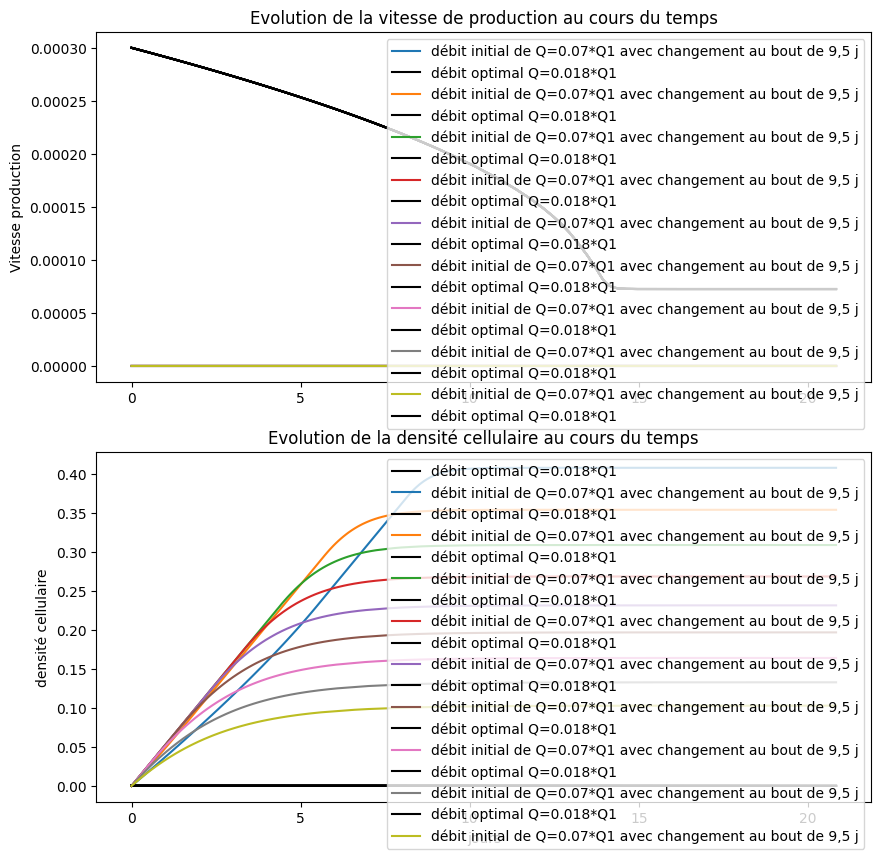

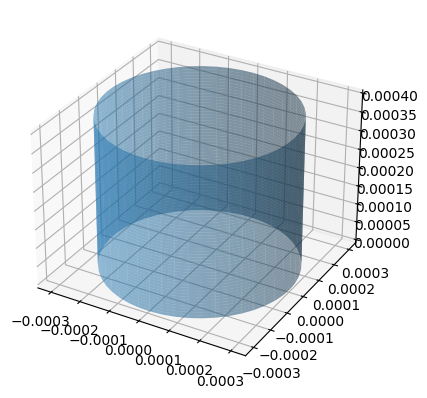

In [24]:

variation_debit(360,5000,[10e-6/(60)*0.1,10e-6/(60)*0.2,10e-6/(60)*0.3,10e-6/(60)*0.4,10e-6/(60)*0.5,10e-6/(60)*0.6,10e-6/(60)*0.7,10e-6/(60)*0.8,10e-6/(60)*0.9]) 

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid
 
from mpl_toolkits.mplot3d import Axes3D as ax
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
a=evolution_R_aleatoire(360,5000)


for i in range(0,len(a[1]),100):
    Xc,Yc,Zc = data_for_cylinder_along_z(0,0,a[0][50][i],Hc)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.5)
    plt.pause(0.01)
 
plt.show()